# Capstone Project Sandboo

Pie charts or stacked histograms for where people live

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

#import drawSvg as draw

C:\Users\Stee\Anaconda3good\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [25]:
class Council(object):
    '''
    '''
    def __init__(self, construct_p, demolish_p):
        self.construct_p = construct_p
        self.demolish_p = demolish_p
    def zone(self, land, to_zone_as):
        land.zoned_as.append(to_zone_as)
    def approve_construction(self, block):
        approval = bool(np.random.binomial(1, construct_p))
        return approval
    def approve_demolition(self, residence):
        approval = bool(np.random.binomial(1, demolish_p))
        return approval

class District(object):
    def __init__(self):
        self.zoned_as = []
        self.blocks = [[]]
    def update(self):
        #REMOVE AND HAVE THIS BE DONE BY COUNCIL?
        self.zoned_as.append(self.zoned_as[-1])
        #Append last time step's blocks
        self.blocks.append([b for b in self.blocks[-1]])        
        
class Block(object):
    def __init__(self, size):
        self.size = size
        self.district = None
        self.zoned_as = []

        self.residences = [[]]
    def update(self):
        #Update zoning per district's zone
        self.zoned_as.append(self.district.zoned_as[-1])
        #Append last time step's residences
        self.residences.append([r for r in self.residences[-1]])

class Developer(object):
    def __init__(self):
        self.residences_built = [[]]
        self.residences_demolished = [[]]
    def can_build_on(self, block, council):
        '''
        Get permission from council to put up a new building.
        '''
        approval = council.approve_construction(block)
        return approval      
    def can_demolish(self, residence, council):
        '''
        Get permission from council to demolish a building.
        '''
        approval = council.approve_demolition(residence) 
        return approval
    def evict_all(self, residence):
        [u.occ[-1].move_out() for u in residence.units[-1] if u.occ[-1]]
    def demolish(self, residence):
        #Make all households move out
        self.evict_all(residence)
        #Remove this residence from the block's list. (Will remove it from all records moving forward.)
        residence.block.residences[-1].remove(residence)
        #Remove the block from this residence
        residence.block = False
        self.residences_demolished[-1].append(residence)
        return residence 
    def build_on(self, block, price_sqft):
        #Buildings in higher-zoned blocks must be somewhat bigger to start with. 
        #(Extremely skinny tall buildings would be strange.)
        min_res_size = (MIN_RES_SIZE * (block.zoned_as[-1] / 2)) if block.zoned_as[-1] != 1 else MIN_RES_SIZE
        max_res_size = min_res_size * (5 * block.zoned_as[-1])
        #Remaining empty land on this block:
        avail_area = block.size - sum([r.size for r in block.residences[-1]])
        #If avail_area not large enough to put up a building
        if  avail_area < min_res_size:
            return
        #If avail area exceeds min residence size that this developer can build
        else:
            # If the max possible size for this building is bigger than half the block somehow
            if max_res_size > (block.size / 2):
                #Max res size gets reduced to half the block size.
                max_res_size = (block.size / 2)
            #Distribution of possible sizes for a new residence
            size_dist = np.arange(min_res_size, max_res_size + 1)
            #Initialize new residence object
            #Give residence a random size within the realm of possibility
            size = np.random.choice(size_dist)
            residence = Residence(block, size, price_sqft)
            #Add residence to last list of residences built on the block
            block.residences[-1].append(residence)
            #Add residence to last list of residence built by this developer
            self.residences_built[-1].append(residence)
            return residence
        
class Residence(object):
    def __init__(self, block, size, price_sqft):
        #Block cannot change after instantiation.
        self.block = block
        #Amount of land taken up by building.
        #Are avail for units may be higher depending on zoning.
        #Size cannot change after instantiation.
        self.size = size
        #Zone cannot change after instantiation.
        self.zoned_as = self.block.zoned_as[-1]
        self.units = [[]]
        #Can have as many floors as allowed by the zoning of the block & district.
        self.floors = 1 if self.zoned_as == 1 else np.random.choice(np.arange(2, self.zoned_as + 1))
        #Create units for residence
        #Amount of area available for units.
        interior = self.size * self.floors
        min_unit_size = MIN_RES_SIZE
        #Max unit size is one entire floor of the building
        max_unit_size = self.size
        #Minimum 1 unit per floor
        min_unit_count = interior / max_unit_size
        #Residences zoned as 1 can only have 1 unit
        #Otherwise can have as many units as will fit on the 'size' times the floors
        max_unit_count = 1 if self.zoned_as == 1 else interior // min_unit_size 
        if self.zoned_as != 1:
            unit_count_range = np.arange(min_unit_count, max_unit_count + 1)
            unit_count = np.random.choice(unit_count_range)
        else:
            unit_count = 1
        unit_size = interior / unit_count
        #Actually create the units nows
        for i in np.arange(unit_count):
            unit = Unit(self, unit_size, price_sqft)
            self.units[-1].append(unit)

class Unit(object):
    def __init__(self, residence, size, price_sqft):
        #Unit cannot be moved into another building or resized.
        self.residence = residence
        self.size = size
        #Cost to rent/own a unit. Should increase slightly over time
        #with inflation. 
        self.value = [(self.size * price_sqft)]
        #Occupant is a list. -1 is current occupant.
        self.occ = [False]
        #Owner, if any. (Otherwise, rented.)
        self.owned_by = [False]
    def update(self):
        self.value.append(self.value[-1])
        self.value[-1] += self.value[-1] * INFLATION
        self.occ.append(self.occ[-1])
        self.owned_by.append(self.owned_by[-1])
    def spike(self, spike):
        self.value[-1] += (self.value[-1] * spike)
        

class Household(object):
    '''
    '''
    def __init__(self, has):
        #Current unit the household is occupying (its 'address')
        #or False if it is not housed.
        self.housed = [False]
        #Whether household owns the unit it is housed in
        self.owns = [False]
        #Household's spending power for housing. Should increase slightly 
        #over time with inflation.
        self.has = [has]
    
    def update(self):
        self.housed.append(self.housed[-1])
        self.owns.append(self.owns[-1])
        self.has.append(self.has[-1])
        self.has[-1] += self.has[-1] * INFLATION 
    
    def can_move_in(self, unit):
        #household needs a place to live
        #unit not already taken
        # household can afford unit 
        if (not self.housed[-1]) \
        and (not unit.occ[-1]) \
        and (unit.value[-1] <= self.has[-1]):        
            return True
        else: 
            return False
    def must_move_out(self):
        #Household has a place to live
        #buts its value has risen above
        #household's spending power
        #Other conditions can be added later
        if (self.housed[-1]) \
        and self.has[-1] < self.housed[-1].value[-1]\
        and not self.owns[-1]:
            return True
        else:
            return False
        
    def move_in(self, unit, own_p):
        #Household becomes occupant of unit
        unit.occ[-1] = self
        #Houshold marks itself as housed
        self.housed[-1] = unit
        #If this is a single family residence (i.e. res with one unit)
        #then there's a chance the hh could own not rent.
        if self.housed[-1].residence.floors == 1:
            own_bool = bool(np.random.binomial(1, own_p))
            #If by chance this household gets to own this unit
            if own_bool:
                #Unit is owned by this household
                self.housed[-1].owned_by[-1] = self
                #This household now owns the unit
                self.owns[-1] = self.housed[-1]
            
    
    def move_out(self):
        #Unit loses occupant
        self.housed[-1].occ[-1] = False
        #Household marks itself as unhoused
        self.housed[-1] = False
        #If the household owns it unit
        if self.owns[-1]:
            #Unit loses owner
            self.owns[-1].owned_by[-1] = False
            #Owner loses unit
            self.owns[-1] = False
            
            

def create_councils(self, council_count, construct_p, demolish_p):
            #Create a council to zone blocks
    councils = []
    for i in range(council_count):
        council = Council(construct_p, demolish_p)
        councils.append(council)
    return councils
        
def create_blocks(self, land):
    new_blocks = []
    size = BLOCK_SIZE
    while land > 0:
        #size = np.round(np.random.choice(block_dist, replace = False), 0)
        #Create a new block only if the block size will fit on the available land left
        if size > land:
            #Need to break the loop here otherwise it keeps running until a random size is
            #drawn that fits the available remaining land. Could be tiny.
            break
        else:
            #Instantiate a block
            block = Block(size)
            #Reduce available land area by the size of this block
            land -= size
            #Add this block to the list of blocks in the sim
            new_blocks.append(block)
    #Append this list to the list of blocks as the last item        
    return new_blocks

def create_districts(self, blocks):
    '''
    Map blocks onto districts evenly.
    '''
    blocks_to_assign = [b for b in blocks]
    districts = []
    for i in range(self.zoning.shape[0]):
        district = District()
        districts.append(district)
    #While there are still blocks to assign
    while blocks_to_assign:
        #For each district
        for d in districts:
            #If the list hasn't run out of values while iterating
            if blocks_to_assign:
                #Give the first block to the district and remove it from the list of blocks
                blocks_to_assign[0].district = d
                d.blocks[-1].append(blocks_to_assign.pop(0))       
            else:
                break
    return districts

def round_of_zoning(self, count, council, districts):
    '''
    Takes one council, not a list of councils.

    '''
    #Zone each district and all its blocks
    for i, d in enumerate(districts):
        #If this spot in the zoning array is not empty, give the district a new zone
        if self.zoning[i][count]:
            council.zone(d, self.zoning[i][count])
        #Just copy over each district's previous zone
        else: 
            d.zoned_as.append(d.zoned_as[-1])
        #In either case, all blocks will get rezoned to match their district
        #when they update()

            
            
def create_developers(self, dev_count):
    '''
    Instantiate some number of developer objects.
    '''
    developers = []
    for i in range(dev_count):
        developer = Developer()
        developers.append(developer)
    #Return developers as a list to be stored
    return developers

def round_of_developing(self, developer, council, blocks, price_sqft):
    '''
    Iterate over list of developers and call each developer's develop method
    '''
    d = developer
    c = council
                        #Return the block if:
                        #the size hte the block minus the sum of the sizes of all its residences
                        #is less than the min res size times the block's zoning, 
                        #or just hte min res size if the block is zoned as 1
    blocks_with_land_avail = [b for b in blocks if (b.size - sum(r.size for r in b.residences[-1])) > \
                                ((MIN_RES_SIZE * (b.zoned_as[-1] / 2)) if b.zoned_as[-1] != 1 else MIN_RES_SIZE)]
    r_built = []
    for b in blocks_with_land_avail:
        #Can build on a block in inverse proportion to the zoning of the block.
        #e.g. Can build 16 times on a zone-1 block, once a zone-16 block.
        build_count = (b.zoned_as[-1] / np.arange(self.zoning_max))
        r_built.extend([d.build_on(b, price_sqft) for i in build_count if d.can_build_on(b, c)])

    print(f'{len(blocks_with_land_avail)} blocks have enough land for new residences.')
    print(f'{len([r for r in r_built if r])} new residences built.')
                
def round_of_demolishing(self, developers, blocks):
    '''
    Iterate over list of developers and call each developer's demolish method
    '''
    #Each residence is eligible for demolition if its floor count is less than
    #the square root of the zoning of its block. (Should capture e.g. 1-floor
    #buildings in blocks rezoned as 4 but not 2, and 4-floor buildings  in blocks
    #rezoned as 16.)
    rs_to_dem = [r for b in blocks for r in b.residences[-1] \
                                  if r.floors < np.sqrt(b.zoned_as[-1]) and len(r.units[-1][0].value) > 1]
    if not rs_to_dem:
        print('No residences can be demolished.')
    else:
        #Get only 1 building per block. Mirrors round_of_developing.
        #Otherwise too many buildings would be destroyed at once!
        rs_on_unique_blocks = [rs_to_dem[0]]
        rs_on_unique_blocks.extend([r for i, r in enumerate(rs_to_dem[1:]) if r.block != rs_to_dem[i - 1].block])
        print(f'{len(rs_on_unique_blocks)} residences are underzoned and could be demolished.')
        r_demolished = [d.demolish(r) for r in rs_on_unique_blocks for d in developers \
            if d.can_demolish(r, self.councils[-1][0])]
        print(f'{len(r_demolished)} residences demolished.')

def create_households(self, pop_growth, has_avg, has_std):
    '''
    Create some number of households to come to the city.
    '''
    income_dist = np.random.normal(scale = has_std, loc = has_avg, size = pop_growth)
    new_households = [Household(i) for i in income_dist]
    #Return the new households as a list
    return new_households

def round_of_moving_in(self):
    '''
    Must be called after time_step() has updated unit and household lists,
    and before round_of_moving_out().
    Prepare lists of units available and unhoused households, then call match()
    to iterate over units to place households in them.
    (What could be a very slow for loop is optimized by preparing shorter lists
    with only the relevant units and households.)
    '''
    #Empty variables to be updated with info for responding to demand later.
    spike = 0
    ceiling = 0
    #print('Round of moving')
    #print('#Prepare units and households for moving.')
    #Prepare units and households for moving.
    #print('#Step 1: Get units available.')
    #Step 1: Get units available.
    ua = sorted([u for u in self.units[-1] if not u.occ[-1]], \
                        key = lambda u: u.value[-1], reverse = True)
    #print(f'{len(ua)} units available')
    #print('#Step 2: Get households seeking unit.')
    #Step 2: Get households seeking unit.
    hh = sorted([h for h in self.households[-1] if not h.housed[-1]], \
                        key = lambda h: h.has[-1], reverse = True)
    #print(f'{len(hh)} households available')
    #print(f'#Step 3: Exclude any units with value above the max spending power of {hh[0].has[-1]}')
    #Step 3: Exclude any units with value above the max spending power 
    #of the households. (Wouldn't be able to rent to anyone)
    ua = [u for u in ua if u.value[-1] <= hh[0].has[-1]]
    #If list is empty, meaning no units are affordable for the richest household
    if not ua:
        print('No affordable units available for households looking.')
        return spike, ceiling
    print(f'{len(ua)} units available for households looking.')
   # print(f'#Step 4: Exclude any households with spending power less than {ua[0].value[-1]}')
    #Step 4: Exclude any households with spending power less than 
    #the lowest unit value. (Wouldn't be able to find a place.)
    #Keep hh same length as or shorter than ua.
    #(No unit can take more than household so there cannot be more hh than ua.)
    hh = [h for i, h in enumerate(hh) if (h.has[-1] >= ua[-1].value[-1]) and \
                                                                    (i < len(ua))]
    #If list is empty, mmeaning no households can afford what's available
    #This should never happen under the above conditional, but leaving it in for now
    if not hh:
        print('No households looking for units.')
        return spike, ceiling
    print(f'{len(hh)} households can afford the units available.')
    #print('#Step 5: call the match function to move households into units.')
    #Step 5: call the match function to move households into units.
    hh_remaining = match(hh, ua, self.own_p)
    
    print(f'{len(hh) - len(hh_remaining)} households out of {len(hh)} found housing.')
    percent_unhoused = len(hh_remaining) / len(hh)
    print(f'{np.round(percent_unhoused, 4)}% of households seeking housing could not find any.')
    
    if percent_unhoused:
        if percent_unhoused < 0.01:
            spike = 0.01
        elif percent_unhoused > 0.2:
            spike = 0.2
        else:
            spike = percent_unhoused
    if hh_remaining:
        ceiling = np.array([h.has[-1] for h in hh_remaining]).max()
    #Return the price spike for unmet demand and the max value housing that can 
    #receive the spike. Prices will rise at end of time step.
    return spike, ceiling

def match(hh_, ua, own_p):
    '''
    Helper function for round of moving. Does the work of matching 
    household to unit. Iterates over units, trying to match each 
    to the highest-value household in the list. If there's a match,
    the household gets popped and the loop moves on to next unit.
    If there's not a match, the loop just moves on to the next unit. 
    A household can take a unit that ncosts less than or equal to
    its spending power. Some rich households may wind up getting 
    cheap units. Units may go untaken; households may go unhoused.

    '''
    #New list to avoid popping the original
    hh = [h for h in hh_]
    #For each unit in list 
    for u in ua:
        #If there are no households left in the list, stop iterating
        if not hh:
            break
        else:
            #If highest-value household can take the unit
            if hh[0].can_move_in(u):
                #Household gets unit
                hh[0].move_in(u, own_p)
                #Household gets removed from list
                hh.pop(0)
            #Else: no lower-valued households can take this unit. 
            #It goes unoccupied. Move on to the next unit.
            #Simplest fastest way to iterate over all of them!
    return hh

def round_of_moving_out(self):
    '''
    Must be called after round_of_moving_in().
    A given household should only move_in and move_out once per time step.
    '''
    #Iterate over all households. If a household is housed but 
    #can no longer afford its unit, it moves out.
    hh_moved_out_count = sum([1 for h in self.households[-1] if h.housed[-1] and \
                        h.must_move_out()])
    
    [h.move_out() for h in self.households[-1] if h.housed[-1] and \
                        h.must_move_out()]
    
    #Should be zero if no hh move out
    print(f'{hh_moved_out_count} households moved out of their unit.')                
                
def print_stats(self, count):
    print(f'Population at time step {count}: {len(self.households[-1])}')
    print(f'{len(self.blocks[-1])} blocks on {LAND} sqft of land')
    print(f'{len(self.developers[-1])} developers')
    #Get number of residences. For now there's no master list for some reason
    residences_count = len(self.residences[-1])
    units_count = len(self.units[-1])
    print(f'{residences_count} residences and {units_count} units')
    housing = [True if household.housed[-1] else False for household in self.households[-1]]
    housed_count = sum(housing)
    homeless_count = len(housing) - housed_count
    print(f'{housed_count} households have housing and {homeless_count} households are unhoused.')
    
class Simulation(object):
    def __init__(self, 
                 #For creating blocks
                 land, zoning, price_sqft,
                 #For bringing builders and rulers to the city
                 dev_count, init_rounds_of_dev, council_count, construct_p, demolish_p,
                 #For bringing people to the city
                 pop_growth, has_avg, has_std, own_p):
        self.zoning = zoning
        self.zoning_max = self.zoning.max()
        self.price_sqft = price_sqft
        #List of increments by which to increase population
        self.pop_growth = pop_growth
        #Held as constant for now
        self.has_avg = has_avg
        #Held as constant for now
        self.has_std = has_std
        self.own_p = own_p
        
        print('Simulation started.')
        #STEP 0:
        #Create councils
        councils = self.create_councils(council_count, construct_p, demolish_p)
        self.councils = [councils]
        
        #STEP 1: 
        #Fill up land area with blocks
        #Will return a list of blocks. Becomes sim.blocks[-1]
        blocks = self.create_blocks(land)
        self.blocks = [blocks]
    
        #Map all blocks onto districts as evenly as possible. 
        #District count is hard coded as a constant
        #This is done randomly, not by a council, as neighborhoods
        #would coalesce organically in real life.
        districts = self.create_districts(self.blocks[-1])
        self.districts = [districts]
        #Council zones all the districts and blocks
        self.round_of_zoning(0, self.councils[-1][0], self.districts[-1])
        #Zone all the blocks to match their dsitrict. 
        #(Hereafter, this will be done autoamtically as part of time steps hereafter.)
        [b.zoned_as.append(d.zoned_as[-1]) for d in self.districts[-1] for b in d.blocks[-1]]
       
        #STEP 2: Create developers to build residences
        developers = self.create_developers(dev_count)
        #Start a list of lists of developers to keep track
        self.developers = [developers]
        #Have developers build new residences
        for round in range(init_rounds_of_dev):
            self.round_of_developing(self.developers[-1][0], self.councils[-1][0], self.blocks[-1], self.price_sqft)
        
        #Start a list of lists of residences
        self.residences = [[r for b in self.blocks[-1] for r in b.residences[-1]]]
        #Start a list of lists of units
        self.units = [[u for r in self.residences[-1] for u in r.units[-1]]]
        
        total_area = 0
        avail_area = 0
        for d in self.districts[-1]:
            total_area += sum([b.size for b in d.blocks[-1]])
            avail_area += sum([b.size - sum([r.size for r in b.residences[-1]]) for b in d.blocks[-1]])
            #print(f'{avail_area} remaining to build on out of {total_area} in district zoned as {d.zoned_as[-1]}')
        #print(f'{avail_area} land remaining to build on out of {total_area} sqft')
        
        #STEP 3: Create people to come to the city and move in
        
        #Pop the last value of population growth
        new_households = self.create_households(self.pop_growth.pop(), 
                               self.has_avg, 
                               self.has_std)
        #Start a list of lists of households to keep track
        self.households = [new_households]
        #STEP 4: Let each household try to move into a house
        spike, ceiling = self.round_of_moving_in()
        
        #STEP 5: Respond to unmet demand
        #LEAVING OUT FOR NOW
        #self.respond_to_demand(spike, ceiling)
        #STEP 6: Print initial statistics

        self.print_stats(0)
        
def time_step(self, arrivals, count):
    
  
    print('\n')
    print(f'Time Step {count}')
    print('\n')
    #Update lists of objects:
    #print(f'1. Copy master list of blocks from time step {count - 1}')
    self.blocks.append([b for b in self.blocks[-1]])
    #print(f'Update zoning of districts')
    self.round_of_zoning(count, self.councils[-1][0], self.districts[-1])
    #print('2. Update each block\'s own records')
    [b.update() for b in self.blocks[-1]]
    #print('3. Update each unit\'s own records')
    #Update each existing unit
    [u.update() for u in self.units[-1]]
    #Also update units in demolished residences, for record-keeping
    [u.update() for d in self.developers[-1] for r in d.residences_demolished[-1] for u in r.units[-1]]
    #Update each existing household
    #print(f'4. Copy list of developers from time step {count - 1}')
    self.developers.append([d for d in self.developers[-1]])
   
    #print(f'5. Copy list of households from time step {count - 1}: ({len(self.households[-1])})')
    #Copy list of households from previous time step
    self.households.append([h for h in self.households[-1]])
    #print(f'6. Update each household\'s own records')
    [h.update() for h in self.households[-1]]
    
    #Inflation increases price_sqft of any new housing
    self.price_sqft += self.price_sqft * INFLATION
    print('Inflation:')
    print(f'Price per sqft of housing is now {self.price_sqft}')
    #Inflation increases has_avg and has_std
    self.has_avg += self.has_avg * INFLATION
    self.has_std += self.has_std * INFLATION
    #New developers
    #Leave out for now
    #Will need to extend [-1] spot of developer list with any new developers
    
    #New households move to town
    print(f'New arrivals:')
    new_households = self.create_households(arrivals, self.has_avg, self.has_std)
    print(f'{len(new_households)} households arrived.')
    self.households[-1].extend(new_households)
    #test to make sure lists of households are updating correctly
    #print([len(h_list) for h_list in self.households])

    #print('8. Developers are building new residences on vacant land')
    #Build new residences on available land
    self.round_of_developing(self.developers[-1][0], self.councils[-1][0], self.blocks[-1], self.price_sqft)
    #Manually append the list of all residences
    #print('9. Updating master of list of residences to include new construction')
    self.residences.append([r for b in self.blocks[-1] for r in b.residences[-1]])
    #Need to manually add units to list for sim
    #print('Appending new units to master list.')
    self.units.append([u for r in self.residences[-1] for u in r.units[-1]])
    total_area = 0
    avail_area = 0
    for d in self.districts[-1]:
        total_area += sum([b.size for b in d.blocks[-1]])
        avail_area += sum([b.size - sum([r.size for r in b.residences[-1]]) for b in d.blocks[-1]])
        #print(f'{avail_area} remaining to build on out of {total_area} in district zoned as {d.zoned_as[-1]}')
    print(f'{avail_area} land remaining to build on out of {total_area}')
    #Have homeless try to move into new places
    print('Households are looking for housing.')
    spike, ceiling = self.round_of_moving_in()
    
    #Have those priced out of their units move out
    #Shoudl always be a different group of people who move in/out within a year
    self.round_of_moving_out()
    
    self.round_of_demolishing(self.developers[-1], self.blocks[-1])
    #Should never demolish a building built this year (too confusing)

    #If there was unmet demand for housing in this time step's ronud of moving in,
    #prices of units below the max spending power of the unhoused shoppers will rise
    #by a certain percent.
    #print(f'Spike: {spike}. Ceiling: {ceiling}.')
    self.respond_to_demand(spike, ceiling)


def respond_to_demand(self, spike, ceiling):        
    if spike and ceiling:
        print('Prices spike!')
        print(f'Unmet demand for housing valued less than {ceiling}')
        print(f'leads to a price spike of {spike * 100}%')
        print(f'for units at or below this value.')
        prices_to_spike = [r for r in self.residences[-1] if r.units[-1][0].value[-1] <= ceiling]
        [u.spike(spike) for r in prices_to_spike for u in r.units[-1]]
        u_spike_count = sum([1 for r in prices_to_spike for u in r.units[-1]])
        print(f'Prices rise for {u_spike_count} units.')
        self.price_sqft += self.price_sqft * spike
        print(f'Price per sqft of new housing also rises to {self.price_sqft}.')
        
def run(self):
    count = 1 
    for arrivals in tqdm(self.pop_growth):
        self.time_step(arrivals, count)
        self.print_stats(count)
        count += 1

        
def draw_residences(drawing, residences, x, y):
    #Hard coded with block 'height' of 5
    residences_sorted = sorted([r for r in residences], key = lambda r: r.size, reverse = True)
    base_y = y
    BLOCK_DEPTH = 5
    max_y = y + BLOCK_DEPTH
    colors = ['dimgray', 'gray', 'darkgray', 'silver', 'lightgray', 'gainsboro', 'whitesmoke', 
          'lightslategray', 'azure', 'oldlace', 'lightcyan', 'palegoldenrod']
    #How many of the 120 points in a 5x24 grid each building gets
    dots = [r.size // 425 for r in residences_sorted]
    #i.e. street frontage in "dots"
    widths = [dot // 5 if (dot // 5) > 0 else 1 for dot in dots]
    #i.e. how far across the depth of the block in "dots".
    #(Most buildings will have a depth of 5, the whole depth of the block.)
    depths = [5 if (dot // 5) > 0 else dot for dot in dots]
    previous_width = 0
    for w, d in zip (widths, depths):
        #If the depth of this building plus the previous would exceed the edge of the block
        if (y + d) > max_y:
            #Go back to y of 0, edge the bottom edge of the block
            y = base_y
            #Start to the right of the previous building, not in front of it
            x += previous_width
        drawing.append(draw.Rectangle(x,y,w,d, 
                                      fill = np.random.choice(colors),
                                      stroke_width = '0.1', stroke = 'black'))
        #Width of this building to use next
        previous_width = w
        #Depth of this buidlign to try to put next building in front of
        y += d

def draw_district(drawing, column_max, blocks, time_step):
#Test of blocks with buildings together

    block = draw.Lines((0), (0),
                      (0), (0 + 5),
                      (0 + 24), (0 + 5),
                      (0 + 24), (0),
                      fill = 'white',
                      close = True,
                      stroke = 'black',
                      stroke_width = '0.2',
                      id = 'block')
    x = 0
    y = 0
    column = 0
    column_max = column_max
    alley = True
    #Draw first block from which to copy the others
    #Second block will actually get drawn on top of this one
    drawing.append(block)
    #for b in sim.districts[-1][0].blocks[-1]:
    for b in blocks:
        
        #Reset for new row above previous
        if column > column_max:
            column = 0
            x = 0
            if alley:
                y += 6
                alley = False
            elif not alley:
                y += 7
                alley = True
        drawing.append(draw.Use('block', x, y))
        draw_residences(drawing, b.residences[time_step], x, y)
        x += 26
        column += 1


In [19]:
#This seems to be too much land
LAND = 10002000

In [ ]:
pop_growth = [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]
LAND = 500010000

In [26]:
LAND = 8000200 
BLOCK_SIZE = 51000
#Currently using this zoning for testing demolition
zoning = np.array([[1, False, False, False, False, False, False, False, False, False],
[1, False, False, False, 8, False, False, False, False, False],
[1, False, False, False, 8, False, False, False, False, False],
[1, False, False, False, 8, False, False, False, False, False],
[1, False, False, False, 16, False, False, False, False, False],
[4, False, False, False, 16, False, False, False, False, False],
[4, False, False, False, 16, False, False, False, False, False],
[4, False, False, False, 16, False, False, False, False, False],
[4, False, False, False, 16, False, False, False, False, False],
[16, False, False, False, False, False, False, False, False, False]])
price_sqft = 1
#For developers:
DEV_COUNT = 1
MIN_RES_SIZE = 425
construct_p = 1
demolish_p = 1
init_rounds_of_dev = 8
COUNCIL_COUNT = 1
pop_growth = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 30000]
#Households:
has_avg = 2500
has_std = 500
own_p = 1
#Money:
INFLATION = 0.02

In [27]:
Simulation.create_councils = create_councils
Simulation.create_blocks = create_blocks
Simulation.create_districts = create_districts
Simulation.round_of_zoning = round_of_zoning
Simulation.create_developers = create_developers
Simulation.round_of_developing = round_of_developing
Simulation.create_households = create_households
Simulation.round_of_moving_in = round_of_moving_in
Simulation.print_stats = print_stats
Simulation.round_of_moving_out = round_of_moving_out
Simulation.round_of_demolishing = round_of_demolishing
Simulation.respond_to_demand = respond_to_demand
Simulation.time_step = time_step
Simulation.run = run

#%%time
#CREATE SIM
sim = Simulation(land = LAND,
                 zoning = zoning,
                 price_sqft = price_sqft,
                 dev_count = DEV_COUNT,
                 construct_p = construct_p,
                 demolish_p = demolish_p,
                 init_rounds_of_dev = init_rounds_of_dev,
                 council_count = COUNCIL_COUNT,
                 pop_growth = pop_growth, 
                 has_avg = has_avg, 
                 has_std = has_std,
                 own_p = own_p
                 )

Simulation started.


C:\Users\Stee\Anaconda3good\lib\site-packages\ipykernel_launcher.py:312: RuntimeWarning: divide by zero encountered in true_divide


156 blocks have enough land for new residences.
1713 new residences built.
80 blocks have enough land for new residences.
1280 new residences built.
80 blocks have enough land for new residences.
644 new residences built.
0 blocks have enough land for new residences.
0 new residences built.
0 blocks have enough land for new residences.
0 new residences built.
0 blocks have enough land for new residences.
0 new residences built.
0 blocks have enough land for new residences.
0 new residences built.
0 blocks have enough land for new residences.
0 new residences built.
23927 units available for households looking.
23927 households can afford the units available.
23900 households out of 23927 found housing.
0.0011% of households seeking housing could not find any.
Population at time step 0: 30000
156 blocks on 8000200 sqft of land
1 developers
3637 residences and 24048 units
23900 households have housing and 6100 households are unhoused.


#  Running a sim

In [28]:
%%time
#Run the simulation for as many time steps as there are columns in the zoning array.
sim.run()



Time Step 1


Inflation:
Price per sqft of housing is now 1.02
New arrivals:
1000 households arrived.
0 blocks have enough land for new residences.
0 new residences built.
-366280.0 land remaining to build on out of 7956000
Households are looking for housing.
No affordable units available for households looking.
0 households moved out of their unit.
10 residences are underzoned and could be demolished.
10 residences demolished.
Population at time step 1: 31000
156 blocks on 8000200 sqft of land
1 developers
3637 residences and 24048 units
23504 households have housing and 7496 households are unhoused.


Time Step 2


Inflation:
Price per sqft of housing is now 1.0404
New arrivals:
1000 households arrived.


C:\Users\Stee\Anaconda3good\lib\site-packages\ipykernel_launcher.py:312: RuntimeWarning: divide by zero encountered in true_divide


5 blocks have enough land for new residences.
10 new residences built.
-348632.0 land remaining to build on out of 7956000
Households are looking for housing.
1111 units available for households looking.
1111 households can afford the units available.
1111 households out of 1111 found housing.
0.0% of households seeking housing could not find any.
0 households moved out of their unit.
No residences can be demolished.
Population at time step 2: 32000
156 blocks on 8000200 sqft of land
1 developers
3637 residences and 24783 units
24615 households have housing and 7385 households are unhoused.


Time Step 3


Inflation:
Price per sqft of housing is now 1.061208
New arrivals:
1000 households arrived.
0 blocks have enough land for new residences.
0 new residences built.
-348632.0 land remaining to build on out of 7956000
Households are looking for housing.
No affordable units available for households looking.
0 households moved out of their unit.
1 residences are underzoned and could be dem

In [3]:
51000 / 2125

24.0

In [6]:
51000 / 425 / 16

7.5

In [8]:
def do_nothing():
    hey = 'hey'
    return
    

In [11]:
example = []
example.append(do_nothing())

In [13]:
example.append('bye')

In [14]:
example

[None, 'bye']

In [15]:
len(example)

2

In [17]:
[e for e in example if e ]

['bye']

# Visualizing a district

In [415]:
[r.size for r in sim.districts[-1][0].blocks[-1][-1].residences[-3]]

[13330.0]

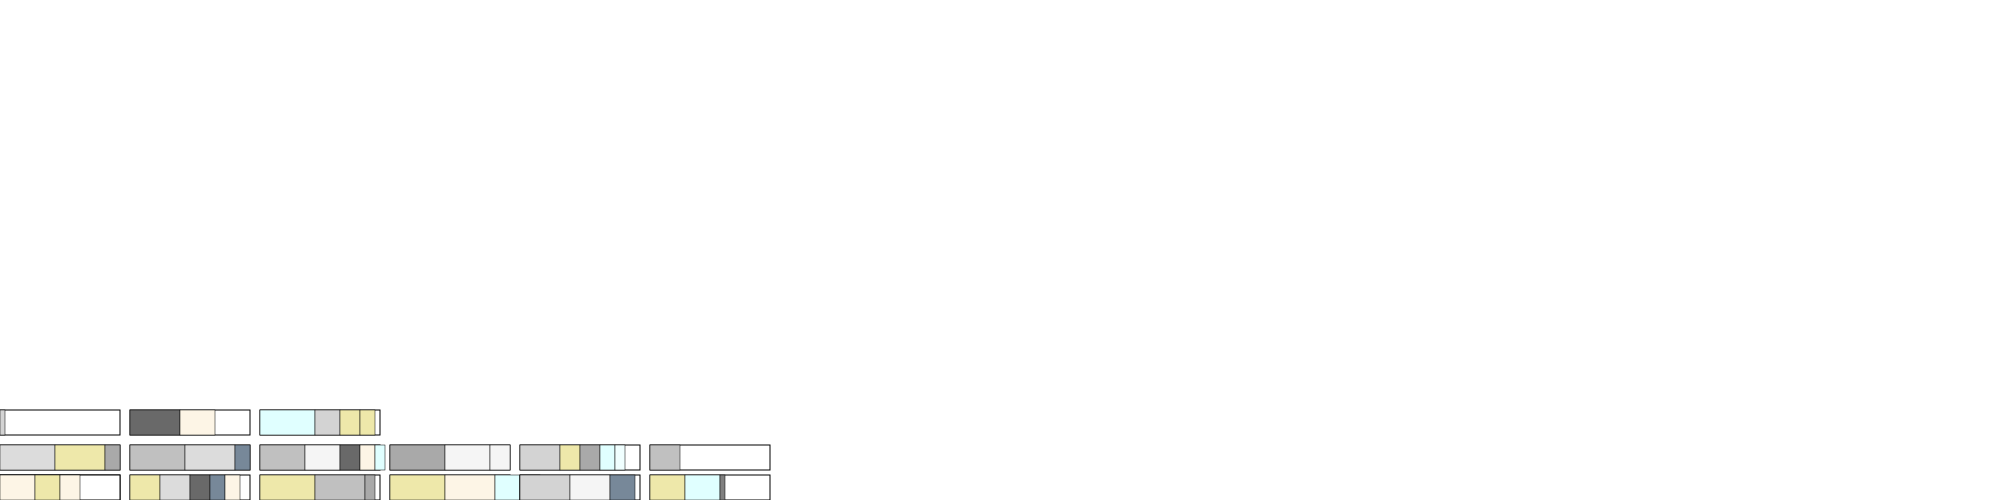

In [140]:
#NOTE FOR LATER: IN ORDER TO DEPICT CHANGE IN CONSTRUCTION OF RESIDENCES OVER TIME,
#NEED TO ADJUST VARIABLES TO ALLOW RESIDENCE LIST FROM SPECIFIC TIEM STEP TO BE CHOSEN
drawing = draw.Drawing(400, 100, origin = (0,0))
draw_district(drawing = drawing, 
              column_max = 5, 
              blocks = sim.districts[-1][9].blocks[-1],
             time_step = 1)
drawing.setPixelScale(5) 

# Visualizing the history


In [144]:
class History(object):
    def __init__(self, simulation):
        '''
        #More info on 'negative indices':
        #Households have 'has' lists of different lengths depending when they entered the sim.
        #Negative index allows loop to get the relevant value from a has list for each year.
        #.e.g. Year -11, year 0 out of 10, gets the -11th, or the first, value from a has list.
        #Year -1, year 10 out of 10, gets the -1th, or last, value from a has list. &c.
        '''
        self.sim = simulation
        
        #BY YEAR:
        #Negative indices to use for lists through time
        b_range = np.flip(np.negative(np.arange(len(sim.blocks))) - 1)
        #####FOR EACH DISTRICT BY YEAR
        area_avail_by_district = [] 
        r_count_by_district = [] 
        r_single_u_count_by_district = []
        r_multi_u_count_by_district = []
        r_size_mean_by_district = [] 
        
        u_count_by_district = []
        u_size_mean_by_district = [] 
        u_value_mean_by_district = []
        
        h_count_by_district = []
        h_has_mean_by_district = []
        h_own_counts_by_district = []
        
        for district in sim.districts[-1]:
            #Get area available by district over time
            area_avail_by_district.append([sum([(b.size - sum([r.size for r in b.residences[i]])) \
                     for b in sim.blocks[i] if b.district == district]) for i in b_range])
            #Number of residences by district over time:
            r_counts = [len([r for b in district.blocks[-1] for r in b.residences[i]]) for i in b_range]
            r_count_by_district.append(r_counts)
            #Number of single-unit residences (single-family homes) by district over time:
            r_single_u_counts = [sum([True for b in district.blocks[-1] for r in b.residences[i] \
                                  if len(r.units[-1]) == 1]) for i in b_range]
            r_single_u_count_by_district.append(r_single_u_counts)
            #Number of multi-unit residences by district over time:
            r_multi_u_counts = [sum([True for b in district.blocks[-1] for r in b.residences[i] \
                                  if len(r.units[-1]) > 1]) for i in b_range]
            r_multi_u_count_by_district.append(r_multi_u_counts)
            
            #Average residence size by district over time:
            #Get sum of unit sizes per residence, not size of each residence
            r_size_sums = [sum([sum([u.size for u in r.units[-1]]) for b in district.blocks[-1] for r in b.residences[i]]) for i in b_range]
            r_size_mean_by_district.append([r_sum / r_count for r_sum, r_count in zip(r_size_sums, r_counts)])
            #Number of units by district over time:
            u_counts = [len([u for b in district.blocks[-1] for r in b.residences[i] for u in r.units[-1]]) for i in b_range]
            u_count_by_district.append(u_counts)
            #Average unit size by district over time:
            u_sums = [sum([u.size for b in district.blocks[-1] for r in b.residences[i] for u in r.units[-1]]) for i in b_range]
            u_size_mean_by_district.append([u_sum / u_count for u_sum, u_count in zip(u_sums, u_counts)])
            #Average unit value by district over time:
            u_values = [sum([u.value[i] for b in district.blocks[-1] for r in b.residences[i] for u in r.units[-1]]) for i in b_range]
            u_value_mean_by_district.append([u_value / u_count for u_value, u_count in zip(u_values, u_counts)])
            #Number of households in each district over time
            #(Calculated by number of occupied units since each unit has one household)
            h_counts = [sum([True for b in district.blocks[-1] for r in b.residences[i] for u in r.units[-1] if u.occ[i]]) for i in b_range]
            h_count_by_district.append(h_counts)
            #Average spending power of households in each district over time
            h_has_sums = [sum([u.occ[i].has[i] for b in district.blocks[-1] for r in b.residences[i] for u in r.units[-1] if u.occ[i]]) for i in b_range]
            h_has_mean_by_district.append([h_sum / h_count if h_count else 0 for h_sum, h_count in zip(h_has_sums, h_counts)])
            #Home ownership by district
            h_own_counts = [sum([bool(u.occ[i].owns[i]) for b in district.blocks[-1] for r in b.residences[i] for u in r.units[-1] if u.occ[i]]) for i in b_range]
            h_own_counts_by_district.append(h_own_counts)
            #NEW ONES HERE
            
            
        #List to populate with dataframes for each district
        self.by_districts = []
        for i, district in enumerate(sim.districts[-1]):
            data = np.array([area_avail_by_district[i],
                         r_count_by_district[i], r_single_u_count_by_district[i], r_multi_u_count_by_district[i],
                                 r_size_mean_by_district[i],
                         u_count_by_district[i], u_size_mean_by_district[i], u_value_mean_by_district[i],
                         h_count_by_district[i],  h_has_mean_by_district[i], h_own_counts_by_district[i]]).T
            columns = ['empty_land',
                        'r_count', 'r_single_u_count', 'r_multi_u_count', 'r_size_mean',
                       'u_count', 'u_size_mean', 'u_value_mean', 
                       'h_count', 'h_income_mean', 'h_owner_count']
            self.by_districts.append(pd.DataFrame(data = data, columns = columns))
            
        
        #####FOR ALL DISTRICTS BY YEAR
        area_avail = sum(arr for arr in np.array(area_avail_by_district))
        
        #Number of residences
        r_count = [len(r_list) for r_list in sim.residences]
        #Average residence size
        #Use sum of unit sizes for each residence, not residence size
        r_size_mean = [(sum([sum([u.size for u in r.units[-1]]) \
                             for r in r_list]) / len(r_list)) for r_list in sim.residences]
        #Number of single-unit residences each year
        r_single_u_count = [sum([True for r in r_list if len(r.units[-1]) == 1]) for r_list in sim.residences]
        #Number of multi-unit residences each year
        r_multi_u_count = [sum([True for r in r_list if len(r.units[-1]) > 1]) for r_list in sim.residences]
        
        #Number of units
        u_count = [len(u_list) for u_list in sim.units]
        #Average unit size
        u_size_mean = [(sum([u.size for u in u_list]) / len(u_list)) for u_list in sim.units]
        #Negative indices to call on lists of varying lengths
        u_range = np.flip(np.negative(np.arange(len(sim.units))) - 1)
        #u_range does not go into dataframe
        #Average unit value
        u_value_mean = [(sum([u.value[i] for u in sim.units[i]]) / len(sim.units[i])) for i in u_range]
        
        h_count = [len(h_list) for h_list in sim.households]
        #hh_range is negative indices by which to call items from has list in each household.
        
        hh_range = np.flip(np.negative(np.arange(len(sim.households))) - 1)
        #hh_range is not included in the dataframe
        #Only households who were housed at the end of each year
        h_housed = [sum([1 for h in sim.households[i] if h.housed[i]]) for i in hh_range]
        #Only households who were unhoused at the end of each year
        h_unhoused = [sum([1 for h in sim.households[i] if not h.housed[i]]) for i in hh_range]
        #Average income of household by year
        h_has_mean = [sum([h.has[i] for h in sim.households[i]])\
                             / len(sim.households[i]) for i in hh_range]
        #Number of households each year who owned their unit
        h_own_count = [sum([True for h in sim.households[i] if h.owns[i]]) for i in hh_range]
        #Number of households each year who rented their unit
        h_rent_count = [sum([True for h in sim.households[i] \
                             if not h.owns[i] and h.housed[i]]) for i in hh_range]
        
        #Average time household spent living in sim by year
        #(i.e. average 'age' of household by year)
        h_age_mean = [sum([len(h.has[:i]) for h in sim.households[i]]\
                                ) / len(sim.households[i]) for i in hh_range]
        
        data = np.array([area_avail,
                         r_count, r_size_mean, r_single_u_count, r_multi_u_count,
                         u_count, u_size_mean, u_value_mean,
                         h_count, h_housed, h_unhoused, h_has_mean, h_own_count, h_rent_count, h_age_mean
                        ]).T
        columns = ['empty_land',
                    'r_count', 'r_size_mean', 'r_single_u_count', 'r_multi_u_count',
                   'u_count', 'u_size_mean', 'u_value_mean', 
                   'h_count', 'h_housed', 'h_unhoused', 'h_income_mean', 'h_own_count', 'h_rent_count', 'h_age_mean']
        
        
        self.all_by_year = pd.DataFrame(data = data, columns = columns).rename_axis('Year')
        
    def get_random_hh(self):
        '''
        Generates statistics for a randomly chosen household.
        '''
        hh = np.random.choice(sim.households[-1])
        hh_range = np.flip(np.negative(np.arange(len(hh.housed))) - 1)
        spending_power = hh.has
        spending_on_housing = [hh.housed[i].value[i] if hh.housed[i] else 0 for i in hh_range]
        size_of_housing = [u.size if u else 0 for u in hh.housed]
        districts_zoned_as = [u.residence.block.district.zoned_as[-1] if u else 0 for u in hh.housed]
        random_hh = pd.DataFrame(data = np.array([spending_power, spending_on_housing, size_of_housing, districts_zoned_as]).T,
                               columns = ['spending_power', 'spending_on_housing', 'size_of_housing', 'districts_zoned_as'])
        return random_hh
        

In [145]:
%%time
hist = History(sim)

Wall time: 1.67 s


In [148]:
hist.by_districts[4]

,empty_land,r_count,r_single_u_count,r_multi_u_count,r_size_mean,u_count,u_size_mean,u_value_mean,h_count,h_income_mean,h_owner_count
0,-5318.0,640.0,640.0,0.0,1283.309375,640.0,1283.309375,1289.671375,640.0,3000.634432,640.0
1,-5318.0,640.0,640.0,0.0,1283.309375,640.0,1283.309375,1315.464802,640.0,3060.647120,640.0
2,-5318.0,640.0,640.0,0.0,1283.309375,640.0,1283.309375,1341.774099,640.0,3121.860063,640.0
3,-5318.0,640.0,640.0,0.0,1283.309375,640.0,1283.309375,1368.609581,608.0,3182.456935,608.0
4,38976.0,608.0,608.0,0.0,1278.000000,608.0,1278.000000,1389.020031,576.0,3246.940267,576.0
5,34021.0,580.0,576.0,4.0,1804.068966,965.0,1084.310881,1199.918747,926.0,2912.709159,544.0
6,-51342.0,558.0,544.0,14.0,3973.112903,2567.0,863.652902,973.297624,1024.0,3025.369332,512.0
7,-54123.0,529.0,512.0,17.0,4911.395085,2698.0,962.982950,1106.505325,1135.0,3119.068561,480.0
8,-35200.0,498.0,480.0,18.0,5560.054217,3033.0,912.926805,1069.639255,1135.0,3181.449932,480.0
9,-29062.0,470.0,448.0,22.0,6709.687234,3720.0,847.729301,1013.114988,1403.0,3184.794174,448.0


In [ ]:
#Number of households in each district over time
            #(Calculated by number of occupied units since each unit has one household)
            h_counts = [sum([1 for b in district.blocks[-1] for r in b.residences[i] for u in r.units[-1] if u.occ[i]]) for i in b_range]
            

In [136]:
h_own_counts_by_district = []
for district in sim.districts[-1]:


In [137]:
h_own_counts_by_district

[[636, 636, 636, 636, 636, 636, 636, 636, 636, 636],
 [628, 628, 628, 596, 564, 532, 500, 468, 468, 436],
 [639, 639, 639, 607, 575, 543, 511, 479, 479, 447],
 [661, 661, 661, 629, 597, 565, 533, 501, 501, 469],
 [640, 640, 640, 608, 576, 544, 512, 480, 480, 448],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [142]:
#HELP CAN"T DO THIS ONE
h_rent_counts_by_district = []
for district in sim.districts[-1]:
    h_rent_counts = [sum([(0 if bool(u.occ[i].owns[i]) == True else 1) for b in district.blocks[-1] for r in b.residences[i] for u in r.units[-1] if u.occ[i]]) for i in b_range]
    h_rent_counts_by_district.append(h_own_counts)

In [143]:
h_rent_counts_by_district

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
h_has_sums = [sum([u.occ[i].has[i] for b in district.blocks[-1] for r in b.residences[i] for u in r.units[-1] if u.occ[i]]) for i in b_range]
            h_has_mean_by_district.append([h_sum / h_count if h_count else 0 for h_sum, h_count in zip(h_has_sums, h_counts)])


# RESUME HERE.

# Looking at districts

In [69]:
#For plotting inflation against prices and incomes
inflation_x = np.arange(len(sim.pop_growth))
inflation_y = []
y = has_avg
for x in inflation_x:
    y += y * INFLATION
    inflation_y.append(y)

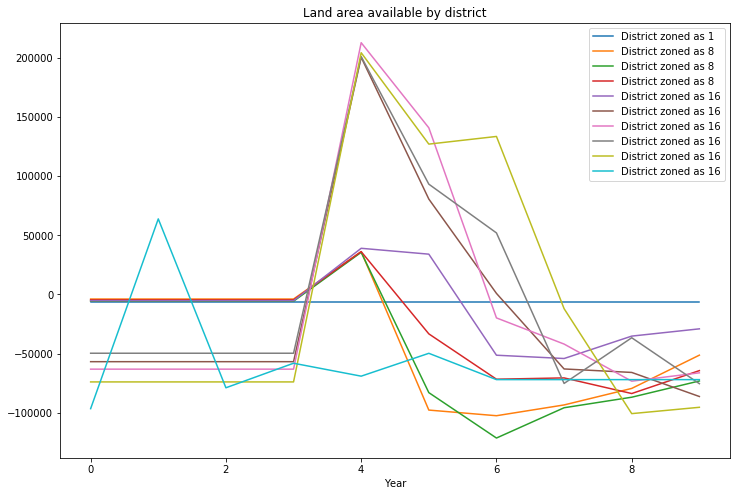

In [51]:
#Districts: available land area
district_labels = [str(d.zoned_as[-1]) for d in sim.districts[-1]]
fig = plt.figure(figsize = (12,8))
for i, label in enumerate(district_labels):
    plt.plot(hist.by_districts[i]['empty_land'], label= 'District zoned as ' + label)
#plt.plot(hist.all_by_year['empty_land'], label = 'Total land area available for building')
plt.xlabel('Year')
plt.legend()
plt.title('Land area available by district')
plt.show()

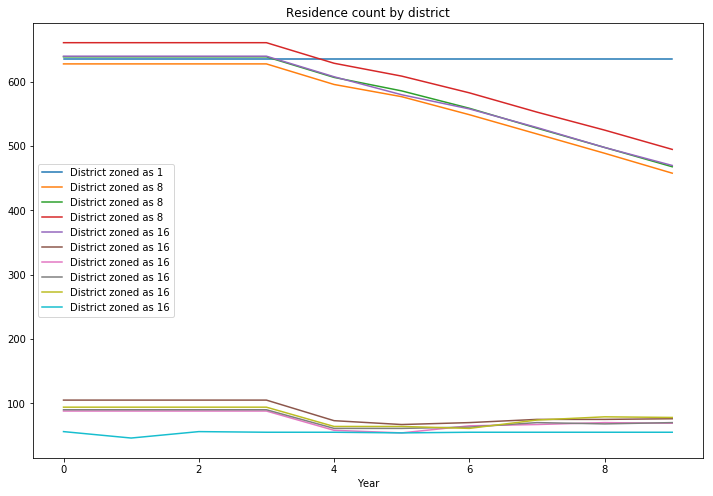

In [52]:
#Districts: residence counts
district_labels = [str(d.zoned_as[-1]) for d in sim.districts[-1]]
fig = plt.figure(figsize = (12,8))
for i, label in enumerate(district_labels):
    plt.plot(hist.by_districts[i]['r_count'], label = 'District zoned as ' + label)
plt.xlabel('Year')
plt.legend()
plt.title('Residence count by district')
plt.show()

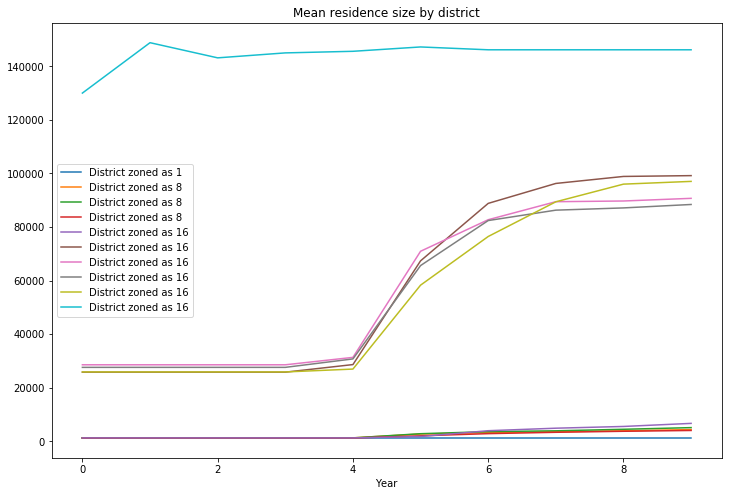

In [53]:
#Districts: mean residence size
district_labels = [str(d.zoned_as[-1]) for d in sim.districts[-1]]
fig = plt.figure(figsize = (12,8))
for i, label in enumerate(district_labels):
    plt.plot(hist.by_districts[i]['r_size_mean'], label = 'District zoned as ' + label)
plt.xlabel('Year')
plt.legend()
plt.title('Mean residence size by district')
plt.show()

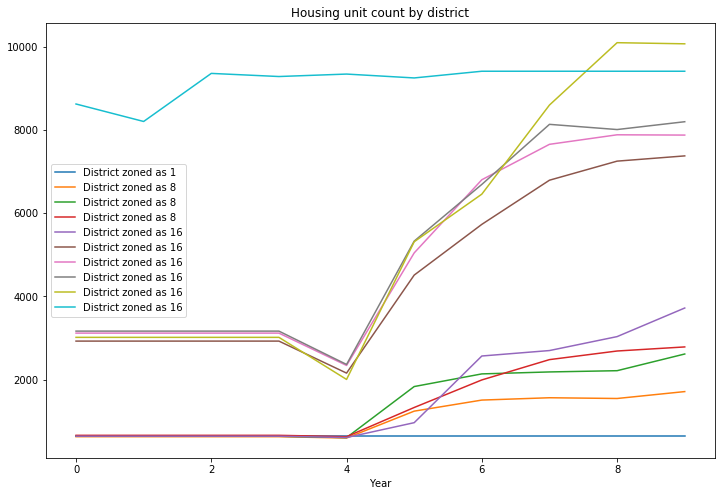

In [54]:
#Districts: housing unit counts
district_labels = [str(d.zoned_as[-1]) for d in sim.districts[-1]]
fig = plt.figure(figsize = (12,8))
for i, label in enumerate(district_labels):
    plt.plot(hist.by_districts[i]['u_count'], label = 'District zoned as ' + label)
plt.xlabel('Year')
plt.legend()
plt.title('Housing unit count by district')
plt.show()

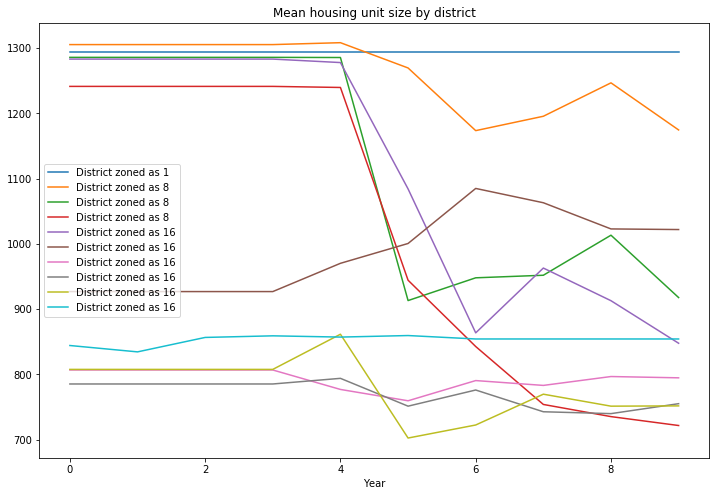

In [73]:
#Districts: mean housing unit size
district_labels = [str(d.zoned_as[-1]) for d in sim.districts[-1]]
fig = plt.figure(figsize = (12,8))
for i, label in enumerate(district_labels):
    plt.plot(hist.by_districts[i]['u_size_mean'], label = 'District zoned as ' + label)
plt.xlabel('Year')
plt.legend()
plt.title('Mean housing unit size by district')
plt.show()

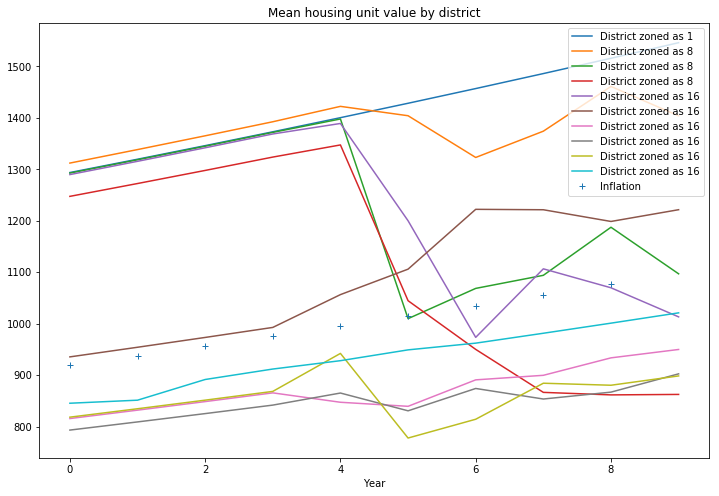

In [77]:
#Districts: mean housing unit value

#Show inflation starting with mean unit value from first time step 
inflation_x = np.arange(len(sim.pop_growth))
inflation_y = []
y = hist.all_by_year['u_value_mean'][0]
for x in inflation_x:
    y += y * INFLATION
    inflation_y.append(y)


district_labels = [str(d.zoned_as[-1]) for d in sim.districts[-1]]
fig = plt.figure(figsize = (12,8))
for i, label in enumerate(district_labels):
    plt.plot(hist.by_districts[i]['u_value_mean'], label = 'District zoned as ' + label)
plt.plot(inflation_x, inflation_y, '+', label ='Inflation')
plt.xlabel('Year')
plt.legend()
plt.title('Mean housing unit value by district')
plt.show()

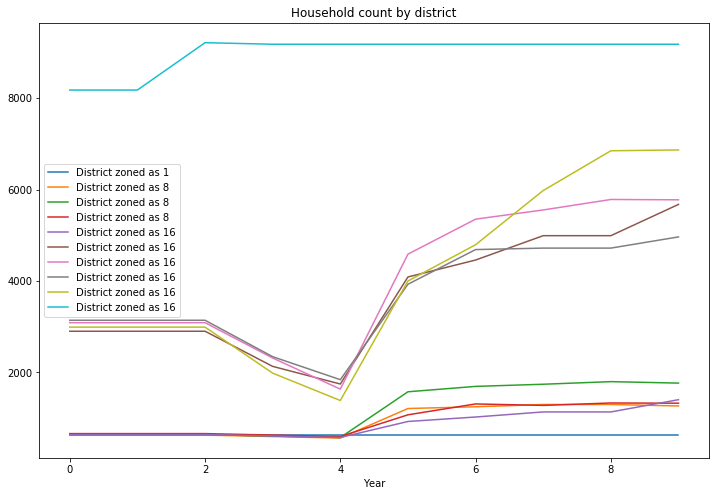

In [65]:
#Districts: household counts
district_labels = [str(d.zoned_as[-1]) for d in sim.districts[-1]]
fig = plt.figure(figsize = (12,8))
for i, label in enumerate(district_labels):
    plt.plot(hist.by_districts[i]['h_count'], label = 'District zoned as ' + label)
plt.xlabel('Year')
plt.legend()
plt.title('Household count by district')
plt.show()

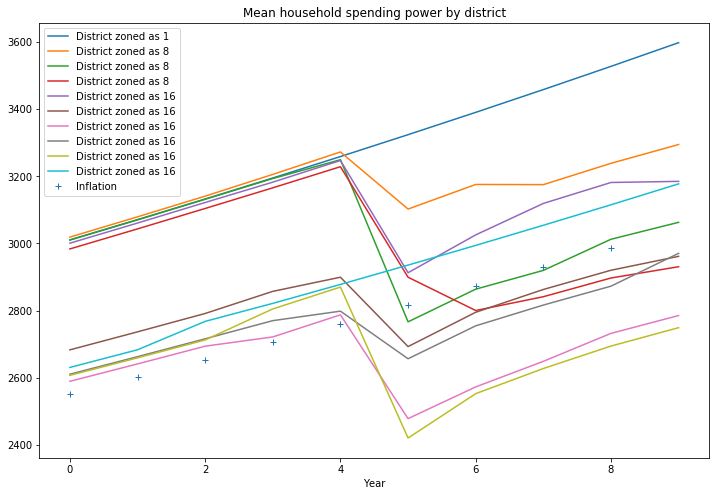

In [78]:
#Districts: household spending power
#Show inflation starting with average spending power from first time step
inflation_x = np.arange(len(sim.pop_growth))
inflation_y = []
y = has_avg
for x in inflation_x:
    y += y * INFLATION
    inflation_y.append(y)

district_labels = [str(d.zoned_as[-1]) for d in sim.districts[-1]]
fig = plt.figure(figsize = (12,8))
for i, label in enumerate(district_labels):
    plt.plot(hist.by_districts[i]['h_income_mean'], label = 'District zoned as ' + label)
plt.plot(inflation_x, inflation_y, '+', label ='Inflation')
plt.xlabel('Year')
plt.legend()
plt.title('Mean household spending power by district')
plt.show()

# Looking at totals

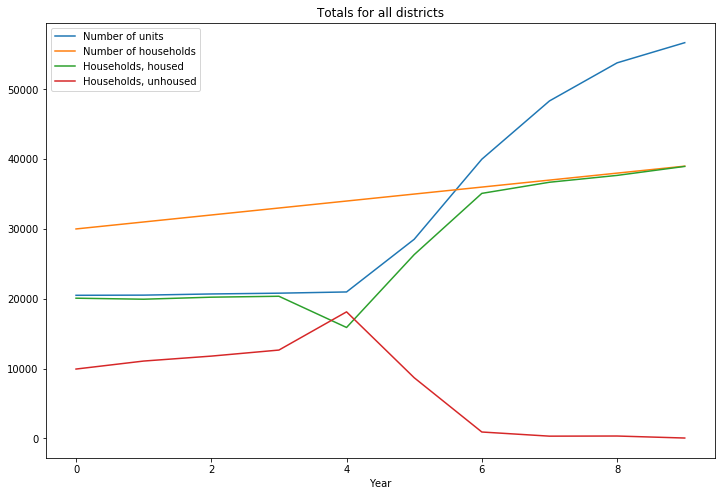

In [138]:
#Housing and households by year
fig = plt.figure(figsize = (12, 8))
plt.plot(hist.all_by_year['u_count'], label = 'Number of units')
plt.plot(hist.all_by_year['h_count'], label = 'Number of households')
plt.plot(hist.all_by_year['h_housed'], label = 'Households, housed')
plt.plot(hist.all_by_year['h_unhoused'], label = 'Households, unhoused')
plt.xlabel('Year')
plt.legend()
plt.title('Totals for all districts')
plt.show()


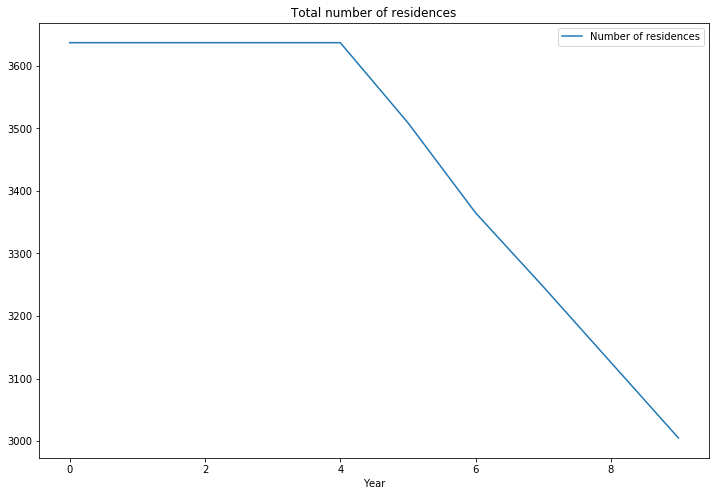

In [79]:
#Housing and households by year
fig = plt.figure(figsize = (12, 8))
plt.plot(hist.all_by_year['r_count'], label = 'Number of residences')
plt.xlabel('Year')
plt.legend()
plt.title('Total number of residences')
plt.show()

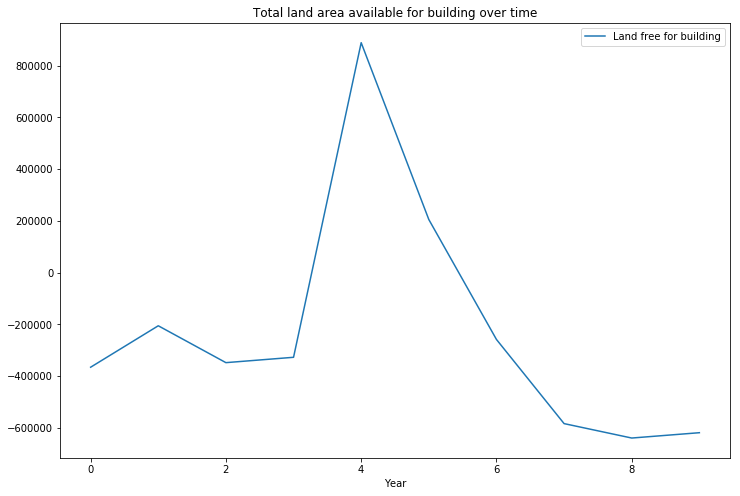

In [80]:
#Land area by year
fig = plt.figure(figsize = (12, 8))
plt.plot(hist.all_by_year['empty_land'], label = 'Land free for building')
#plt.plot(hist.all_by_year['r_count'], label = 'Number of residences')

plt.xlabel('Year')
plt.legend()
plt.title('Total land area available for building over time')
plt.show()

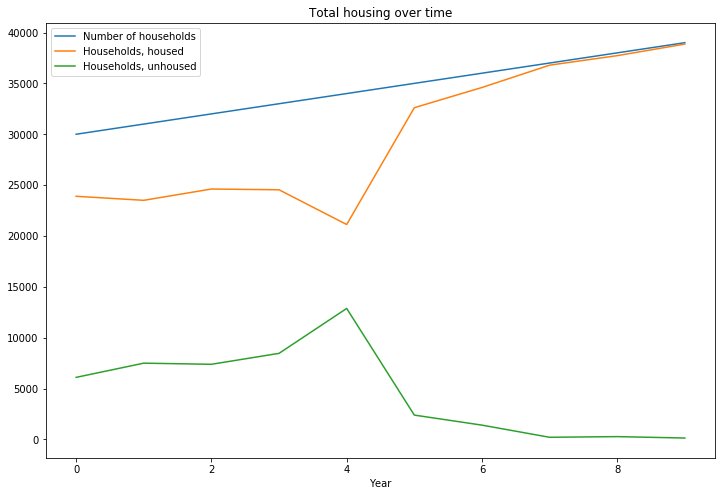

In [81]:
#Look at households in city by year
fig = plt.figure(figsize = (12, 8))

plt.plot(hist.all_by_year['h_count'], label = 'Number of households')
plt.plot(hist.all_by_year['h_housed'], label = 'Households, housed')
plt.plot(hist.all_by_year['h_unhoused'], label = 'Households, unhoused')

plt.xlabel('Year')
plt.legend()
plt.title('Total housing over time')
plt.show()



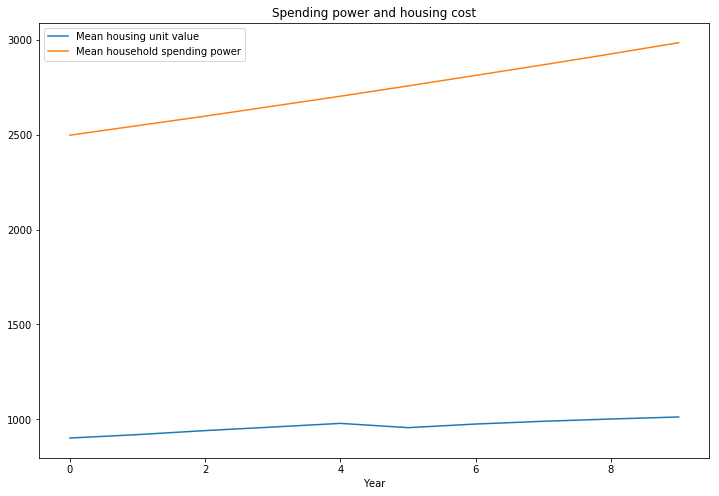

In [82]:
#Look at household spending power versus housing costs
fig = plt.figure(figsize = (12, 8))
plt.plot(hist.all_by_year['u_value_mean'], label = 'Mean housing unit value')
plt.plot(hist.all_by_year['h_income_mean'],  label = 'Mean household spending power')
plt.xlabel('Year')
plt.legend()
plt.title('Spending power and housing cost')
plt.show()

# VARIOUS CHECKS FOR OBJECTS IN SIM

In [ ]:
#For debugging mismatched list lengths in history object
# for i, d in enumerate(sim.districts[-1]):
#     print(f'district {i}')
#     print('\n')
#     for b_ in b_range:
#         print(f'time step {b_}')
#         for j, b in enumerate(d.blocks[-1]):
#             print(f'block {j}')
#             for k, r in enumerate(b.residences[i]):
#                 print(f'residence {k}')
#                 for l, u in enumerate(r.units[-1]):
#                     print(f'unit {l}')
#                     print(u.occ[i].has[i] if u.occ[i] else u.occ[i])

In [ ]:
#Zoning of each district
#[d.zoned_as[-1] for d in sim.districts[-1]]

#How many blocks per district
#[len(d.blocks[-1]) for d in sim.districts[-1]]

#CHECK FOR UNIT COUNTS IN DIFFERENT SIZED RESIDENCES
#how to write nested comp: smallest for biggest in biggest for second biggest in second biggest for third biggest in third biggest
#r_sizes = [r.size for d in sim.districts[-1] for b in d.blocks[-1] for r in b.residences[-1]]
#r_unit_count = [len(r.units[-1]) for d in sim.districts[-1] for b in d.blocks[-1] for r in b.residences[-1]]
#for size, unit_count in zip(r_sizes, r_unit_count):
#    print(size, unit_count)

In [ ]:
#For history object
#Test for lengths of these lists. They should all be equal length.
# print(len(residences_count))
# print(len(residence_size_avg))
# print(len(units_count))
# print(len(unit_size_avg))
# print(len(unit_value_avg))
# print(len(household_count))
# print(len(households_housed))
# print(len(households_unhoused))
# print(len(household_age_avg))
# print(len(household_has_avg))

In [ ]:
#This is the available area on one lot
#(sim.lots[0][0].size - sum([r.size for r in sim.lots[0][0].residences[0]]))

#Available area for all lots in one year
#[(l.size - sum([r.size for r in l.residences[0]])) \
#     for l in sim.lots[0]]

#Total area for one year vs avail area for one year
#total = sum([l.size  for l in sim.lots[0]])
#avail = sum([(l.size - sum([r.size for r in l.residences[0]])) \
     #for l in sim.lots[0]])

In [ ]:
#Check sizes of all lots
#sum([lot.size for lot in sim.lots[-1]])

In [ ]:
#Check size of each residence
#[residence.size for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check size of each unit
#unit_sizes = [unit.value for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]]

In [ ]:
#Check area of each residence that isn't carved into units
#[(residence.size - sum(unit.size for unit in residence.units[-1])) for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check unbuilt land of each lot
#avail_area = [lot.size - sum([residence.size for residence in lot.residences[-1]]) for lot in sim.lots[-1]]
#Avail area on each lot should be less than min_size for building a new residence
#avail_area

In [ ]:
#Check how many residences on each lot
#[len(lot.residences[-1]) for lot in sim.lots[-1]]

In [ ]:
#Check how many units in each residence
#[len(residence.units[-1]) for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check a single lot
#vars(sim.lots[-1][0])

In [ ]:
#Check a single residence on a lot
#vars(sim.lots[-1][0].residences[-1][0])

In [ ]:
#Check a single unit in a residence
#vars(sim.lots[-1][0].residences[-1][0].units[-1][0])

In [ ]:
#THIS IS GREAT CODE DON'T DELETE
#Check all unit values
#How to quadruple nest a list comprehension:
#smallest for biggest in biggest for second biggest in second biggest for third biggest in third biggest
unit_values = [unit.value[-1] for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]]
#unit_values
#plt.hist(unit_values)

In [ ]:
#Get total number of units in all residences on all lots
len([unit.value[-1] for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]])

In [ ]:
#Check incomes for all households
#incomes = [household.has[-1] for household in sim.households[-1]]
#plt.hist(incomes)

In [ ]:
#Check incomes for currently housed households
#incomes_currently_housed = [household.has[-1] for household in sim.households[-1] if household.housed[-1]]
#plt.hist(incomes_currently_housed)

In [ ]:
#Check housing history for all households
#housing_history = [household.housed for household in sim.households[-1]]
#housing_history

In [ ]:
# #Test for instantiation of lots, residences built by developers, units per residence
# for lot in sim.lots[-1]:
#     print('Lot size:', lot.size)
#     print('Number of buildings on lot:', len(lot.residences[-1]))
#     for residence in lot.residences[-1]:
#         print('Building size:', residence.size)
#         print('Building zoned as:', residence.zoned_as)
#         print('Units in building:', len(residence.units[-1]))
#         print('Sqft per unit:', residence.size / len(residence.units[-1]))
#         for unit in residence.units[-1]:
#             print('Unit size:', unit.size)
#             print('Unit initial value:', unit.value[0])
#             print('Unit current value:', unit.value[-1])
#             print('Household size:', unit.occ[-1].size)
#             print('Household spending power:', unit.occ[-1].size)
#     print('\n')